# Stations EDA - Reggio Calabria

Team: Codellera Andina
Authors:
María Fernanda Molina
Nataly Sarmiento
Isabela Saud 

This notebook explores the ECAD weather station network around Reggio di Calabria. It loads the GADM boundaries and ECAD station metadata, converts station coordinates to lat/lon, filters to Italian stations, finds the nearest stations to the Reggio AOI, and visualizes them on maps (all Italy + zoom on Reggio). The goal is to understand where ground stations are available and which ones can be used as proxies to validate ERA5 and downscaled temperature data for Reggio.

## 1. Imports and basic configuration

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# Show plots inline (standard in Jupyter)
%matplotlib inline

# Make plots a bit nicer/bigger by default
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# In this case the data lives in local D:\Polimi\GenHack 2025\Data 
DATA_DIR = Path(r"D:\Polimi\GenHack 2025\Data")

# GADM admin boundaries (they gave you this file)
GADM_PATH = DATA_DIR / "gadm_410_europe.gpkg"

# Folder with the unzipped ECAD stations for TX (ECA_blend_tx)
STATIONS_DIR = DATA_DIR / "ECA_blend_tx"

print("Data dir:", DATA_DIR.resolve())
print("GADM path exists:", GADM_PATH.exists())
print("Stations dir exists:", STATIONS_DIR.exists())

COUNTRY_CODE = "ITA"              # Italy
AOI_NAME_LEVEL = "NAME_2"         # we will use level-2 name
AOI_NAME = "Reggio Di Calabria"   # exact string from GADM (capital D)

print("AOI country:", COUNTRY_CODE)
print("AOI name:", AOI_NAME, f"(field: {AOI_NAME_LEVEL})")



Data dir: D:\Polimi\GenHack 2025\Data
GADM path exists: True
Stations dir exists: True
AOI country: ITA
AOI name: Reggio Di Calabria (field: NAME_2)


## 2. Load GADM and build AOI for Reggio Di Calabria

Total rows in GADM: 106252
Rows for Italy: 8100
Rows for Reggio Di Calabria (raw): 96


,NAME_0,NAME_1,NAME_2
64891,Italy,Calabria,Reggio Di Calabria


reggio_aoi rows: 1


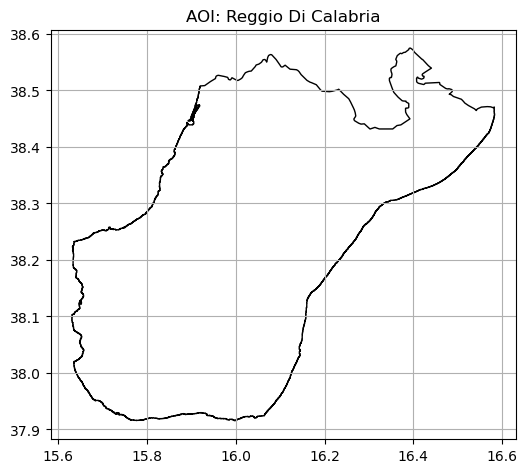

In [14]:
# Load all Europe boundaries
gadm = gpd.read_file(GADM_PATH)
print("Total rows in GADM:", len(gadm))

# Filter to Italy
gadm_ita = gadm[gadm["GID_0"] == COUNTRY_CODE].copy()
print("Rows for Italy:", len(gadm_ita))

# Filter to Reggio Di Calabria within Calabria
mask_reggio = (
    (gadm_ita[AOI_NAME_LEVEL] == AOI_NAME) &
    (gadm_ita["NAME_1"] == "Calabria")
)

reggio = gadm_ita[mask_reggio].copy()
print("Rows for Reggio Di Calabria (raw):", len(reggio))

display(reggio[["NAME_0", "NAME_1", "NAME_2"]].drop_duplicates())

# Dissolve to a single polygon for the AOI
reggio_aoi = reggio.dissolve()

print("reggio_aoi rows:", len(reggio_aoi))

# Plot AOI
ax = reggio_aoi.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
plt.title(f"AOI: {AOI_NAME}")
plt.show()


## 3. Explore station data folder (ECA_blend_tx) 

In [15]:
from pathlib import Path

print("Station dir:", STATIONS_DIR.resolve())
station_files = list(STATIONS_DIR.iterdir())
print("Total files:", len(station_files))
print("First 30 files:")
for f in station_files[:30]:
    print("-", f.name)


Station dir: D:\Polimi\GenHack 2025\Data\ECA_blend_tx
Total files: 8572
First 30 files:
- date_timestamp.txt
- elements.txt
- sources.txt
- stations.txt
- TX_STAID000001.txt
- TX_STAID000002.txt
- TX_STAID000003.txt
- TX_STAID000004.txt
- TX_STAID000005.txt
- TX_STAID000006.txt
- TX_STAID000007.txt
- TX_STAID000008.txt
- TX_STAID000009.txt
- TX_STAID000010.txt
- TX_STAID000011.txt
- TX_STAID000012.txt
- TX_STAID000013.txt
- TX_STAID000014.txt
- TX_STAID000015.txt
- TX_STAID000016.txt
- TX_STAID000021.txt
- TX_STAID000022.txt
- TX_STAID000023.txt
- TX_STAID000024.txt
- TX_STAID000025.txt
- TX_STAID000026.txt
- TX_STAID000027.txt
- TX_STAID000028.txt
- TX_STAID000029.txt
- TX_STAID000030.txt


In [21]:
# Find the header line in stations.txt 

meta_path = STATIONS_DIR / "stations.txt"
print("Metadata file exists:", meta_path.exists())

header_line_idx = None
with open(meta_path, "r", encoding="latin1") as f:
    for i, line in enumerate(f):
        if line.startswith("STAID"):
            header_line_idx = i
            print("Found header at line index:", i)
            print("Header line content:", line.strip())
            break

if header_line_idx is None:
    raise RuntimeError("Could not find header line starting with 'STAID'!")

Metadata file exists: True
Found header at line index: 17
Header line content: STAID,STANAME                                 ,CN,      LAT,       LON,HGHT


In [22]:
# Read station metadata as CSV from the header line 
stations_meta_raw = pd.read_csv(
    meta_path,
    skiprows=header_line_idx,  # skip everything *before* 'STAID,...'
    sep=",",
    engine="python"
)

print("Raw metadata shape:", stations_meta_raw.shape)
stations_meta_raw.head()


Raw metadata shape: (8568, 6)


,STAID,STANAME,CN,LAT,LON,HGHT
0,1,VAEXJOE,SE,+56:52:00,+014:48:00,166
1,2,FALUN,SE,+60:37:00,+015:37:00,160
2,3,STENSELE,SE,+65:04:00,+017:09:59,325
3,4,LINKOEPING,SE,+58:24:00,+015:31:59,93
4,5,LINKOEPING-MALMSLAETT,SE,+58:24:00,+015:31:59,93


In [23]:
# Clean columns and create `stations_meta`
# strip spaces from column names
stations_meta_raw.columns = [c.strip() for c in stations_meta_raw.columns]

# make a working copy
stations_meta = stations_meta_raw.copy()

# basic cleaning of some fields
stations_meta["STAID"] = stations_meta["STAID"].astype(int)
stations_meta["STANAME"] = stations_meta["STANAME"].str.strip()
stations_meta["CN"] = stations_meta["CN"].str.strip()

print("Cleaned columns:", stations_meta.columns.tolist())
stations_meta.head()


Cleaned columns: ['STAID', 'STANAME', 'CN', 'LAT', 'LON', 'HGHT']


,STAID,STANAME,CN,LAT,LON,HGHT
0,1,VAEXJOE,SE,+56:52:00,+014:48:00,166
1,2,FALUN,SE,+60:37:00,+015:37:00,160
2,3,STENSELE,SE,+65:04:00,+017:09:59,325
3,4,LINKOEPING,SE,+58:24:00,+015:31:59,93
4,5,LINKOEPING-MALMSLAETT,SE,+58:24:00,+015:31:59,93


In [24]:
# Helper to convert DMS ('+DD:MM:SS') to decimal degrees 

import numpy as np

def dms_to_dd(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if not s:
        return np.nan

    # Sign
    sign = -1 if s[0] == "-" else 1
    if s[0] in "+-":
        s = s[1:]

    parts = s.split(":")
    if len(parts) != 3:
        return np.nan

    d, m, sec = map(float, parts)
    return sign * (d + m/60.0 + sec/3600.0)

stations_meta["LAT_dd"] = stations_meta["LAT"].apply(dms_to_dd)
stations_meta["LON_dd"] = stations_meta["LON"].apply(dms_to_dd)

stations_meta[["STAID", "STANAME", "CN", "LAT", "LAT_dd", "LON", "LON_dd"]].head()



,STAID,STANAME,CN,LAT,LAT_dd,LON,LON_dd
0,1,VAEXJOE,SE,+56:52:00,56.866667,+014:48:00,14.800000
1,2,FALUN,SE,+60:37:00,60.616667,+015:37:00,15.616667
2,3,STENSELE,SE,+65:04:00,65.066667,+017:09:59,17.166389
3,4,LINKOEPING,SE,+58:24:00,58.400000,+015:31:59,15.533056
4,5,LINKOEPING-MALMSLAETT,SE,+58:24:00,58.400000,+015:31:59,15.533056


In [25]:
# Convert to GeoDataFrame 

geometry = gpd.points_from_xy(stations_meta["LON_dd"], stations_meta["LAT_dd"])
stations_gdf = gpd.GeoDataFrame(
    stations_meta,
    geometry=geometry,
    crs="EPSG:4326"
)

print("Total stations:", len(stations_gdf))
stations_gdf.head()


Total stations: 8568


,STAID,STANAME,CN,LAT,LON,HGHT,LAT_dd,LON_dd,geometry
0,1,VAEXJOE,SE,+56:52:00,+014:48:00,166,56.866667,14.800000,POINT (14.8 56.86667)
1,2,FALUN,SE,+60:37:00,+015:37:00,160,60.616667,15.616667,POINT (15.61667 60.61667)
2,3,STENSELE,SE,+65:04:00,+017:09:59,325,65.066667,17.166389,POINT (17.16639 65.06667)
3,4,LINKOEPING,SE,+58:24:00,+015:31:59,93,58.400000,15.533056,POINT (15.53306 58.4)
4,5,LINKOEPING-MALMSLAETT,SE,+58:24:00,+015:31:59,93,58.400000,15.533056,POINT (15.53306 58.4)


In [26]:
#  Filter to Italian stations and intersect with Reggio AOI 

# 1) Italian stations only
stations_it = stations_gdf[stations_gdf["CN"] == "IT"].copy()
print("Italian stations:", len(stations_it))

# 2) Ensure AOI is in EPSG:4326
reggio_aoi_4326 = reggio_aoi.to_crs("EPSG:4326")

# 3) Spatial join: which Italian stations fall inside AOI?
stations_it_in_reggio = gpd.sjoin(
    stations_it,
    reggio_aoi_4326,
    how="inner",
    predicate="intersects"
)

print("Italian stations in Reggio AOI:", len(stations_it_in_reggio))
stations_it_in_reggio[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd", "HGHT"]].head()


Italian stations: 1112
Italian stations in Reggio AOI: 0


,STAID,STANAME,CN,LAT_dd,LON_dd,HGHT


In [44]:
#  Find nearest Italian stations to Reggio AOI 

# 1) Bounding box around Reggio (in degrees)
minx, miny, maxx, maxy = reggio_aoi_4326.total_bounds
print("Reggio bbox (lon/lat):", minx, miny, maxx, maxy)

# Add a margin of 1 degree (~100 km) around Reggio
margin_deg = 1.0

stations_candidate = stations_it[
    (stations_it["LON_dd"] >= minx - margin_deg) &
    (stations_it["LON_dd"] <= maxx + margin_deg) &
    (stations_it["LAT_dd"] >= miny - margin_deg) &
    (stations_it["LAT_dd"] <= maxy + margin_deg)
].copy()

print("Candidate Italian stations near Reggio (bbox filter):", len(stations_candidate))

# 2) Reproject to a metric CRS (UTM zone 33N works well for Southern Italy)
CRS_PROJECTED = "EPSG:32633"

reggio_aoi_utm = reggio_aoi_4326.to_crs(CRS_PROJECTED)
stations_candidate_utm = stations_candidate.to_crs(CRS_PROJECTED)

# Centroid of Reggio AOI in projected CRS
aoi_centroid_utm = reggio_aoi_utm.geometry.iloc[0].centroid

# 3) Distance in meters from each candidate station to Reggio centroid
stations_candidate_utm["dist_to_reggio_m"] = stations_candidate_utm.geometry.distance(aoi_centroid_utm)

# 4) Take the 5 closest stations
nearest_stations = stations_candidate_utm.sort_values("dist_to_reggio_m").head(5)

print("10 Italian stations closest to Reggio Di Calabria AOI (in meters):")
nearest_stations[["STAID", "STANAME", "CN", "LAT_dd", "LON_dd", "HGHT", "dist_to_reggio_m"]]



Reggio bbox (lon/lat): 15.630417825000052 37.91541671900012 16.583195001000092 38.57483300000007
Candidate Italian stations near Reggio (bbox filter): 31
10 Italian stations closest to Reggio Di Calabria AOI (in meters):


,STAID,STANAME,CN,LAT_dd,LON_dd,HGHT,dist_to_reggio_m
8519,28026,MESSINA,IT,38.258333,15.561389,421,41191.277917
8555,28062,SAN PIER NICETO,IT,38.123056,15.359444,617,60260.094435
8562,28069,TORREGROTTA,IT,38.195833,15.340278,45,60703.106830
8502,28009,FIUMEDINISI,IT,38.033056,15.374167,420,61989.338134
8475,27982,ANTILLO,IT,37.976944,15.260000,772,73639.584247


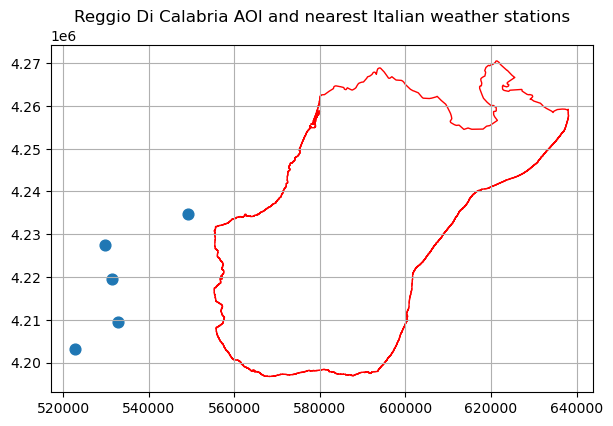

In [45]:
#  Plot Reggio AOI and nearest Italian stations 

ax = reggio_aoi_utm.plot(
    edgecolor="red",
    facecolor="none",
    figsize=(7, 7)
)

nearest_stations.plot(ax=ax, markersize=60)
plt.title("Reggio Di Calabria AOI and nearest Italian weather stations")
plt.show()
